### Dask LD Prune Prototype

In [1]:
import dask
import dask.array as da
import numpy as np
from numba import jit
import plotly.graph_objects as go
from IPython.display import Image
dask.config.set(scheduler='processes')

### Load Random Data

In [2]:
# X = da.random.randint(0, 3, size=(500, 30), dtype=np.uint8)
# X.shape
# pos = np.array(
#     [[1, 1]] * 300 + 
#     [[2, 1]] * 100 + 
#     [[3, 1]] * 75 + 
#     [[4, 1]] * 25
# )
# len(pos)

### Load HapMap Data

In [3]:
X = da.from_zarr('/home/eczech/data/gwas/benchmark/datasets/ld_prune/lsh/hapmap-sr=0.1.zarr')
X = X[::8]
X

dask.array<getitem, shape=(1307, 165), dtype=int8, chunksize=(1307, 165), chunktype=numpy.ndarray>

In [4]:
# Generate (contig, position) vector
pos = np.array(
    [[1, 1]] * X.shape[0]
)
len(pos)

1307

In [5]:
assert len(X) == len(pos)

### Compute Chunk Alignment

In [6]:
from dataclasses import dataclass
from typing import List

@dataclass(frozen=True)
class ChunkContigInfo:
    contig_index: int
    contig_value: int
    chunk_idx: List[int]
    chunk_size: List[int]
        
@dataclass(frozen=True)
class ChunkInfo:
    chunks: List[ChunkContigInfo]

    def get_contig_chunk_boundary(self):
        """ Get index in last chunk for each contig keyed by chunk index """
        bounds = {}
        for c in self.chunks:
            bounds[c.chunk_idx[-1]] = c.chunk_size[-1]
        return bounds
    
    def get_chunk_offset(self):
        """ Get global offset for first row index in each chunk keyed by chunk index """
        offsets = {}
        o = 0
        for c in self.chunks:
            for i, s in zip(c.chunk_idx, c.chunk_size):
                offsets[i] = o
                o += s
        return offsets

        
def get_chunk_info(pos, size):
    chunks = []
    csct = 0
    for i, (v, c) in enumerate(zip(*np.unique(pos[:,0], return_counts=True))):
        sizes = [size] * (c//size) 
        if c % size > 0:
            sizes += [int(c % size)]
        idx = [j + csct for j in range(len(sizes))]
        csct += len(sizes)
        chunks.append(ChunkContigInfo(contig_index=i, contig_value=v, chunk_idx=idx, chunk_size=sizes))
    return ChunkInfo(chunks)

# Calculate chunk sizes with boundaries determined by contigs and a maximum row limit
get_chunk_info(pos, 40).chunks

[ChunkContigInfo(contig_index=0, contig_value=1, chunk_idx=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32], chunk_size=[40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 27])]

In [7]:
# Eventual wrapper method to run rechunking and other metadata calculations
def prune(X, pos, window, step, normalize=True, align_chunks=True, windows_per_chunk=10):
    assert step < window
    assert window % step == 0
    assert X.ndim == 2
    
    chunk_size = windows_per_chunk * window 
    chunk_info = get_chunk_info(pos, chunk_size)
    chunk_lens = tuple(
        cs
        for ci in chunk_info.chunks
        for cs in ci.chunk_size
    )
    
    if not align_chunks and X.chunks[0] != chunk_lens:
        raise ValueError(f'Expected chunks {chunk_lens}, found {X.chunks[0]}')
    if align_chunks:
        X = X.rechunk(chunks=(chunk_lens, X.chunks[1]))
        
    # This is the amount each block should overlap
    overlap_depth = window - step
    
    return X, chunk_info, overlap_depth

In [8]:
window = 100
step = 10
Xp, chunk_info, overlap_depth = prune(X, pos, window, step, windows_per_chunk=3)
Xp

dask.array<rechunk-merge, shape=(1307, 165), dtype=int8, chunksize=(300, 165), chunktype=numpy.ndarray>

In [9]:
chunk_info.chunks

[ChunkContigInfo(contig_index=0, contig_value=1, chunk_idx=[0, 1, 2, 3, 4], chunk_size=[300, 300, 300, 300, 107])]

In [10]:
Xp.chunks

((300, 300, 300, 300, 107), (165,))

In [11]:
Xp.map_blocks(lambda x: np.array([x.shape[0]]), dtype=int, drop_axis=[1]).compute()

array([300, 300, 300, 300, 107])

In [12]:
chunk_info.get_contig_chunk_boundary()

{4: 107}

In [13]:
chunk_info.get_chunk_offset()

{0: 0, 1: 300, 2: 600, 3: 900, 4: 1200}

In [14]:
overlap_depth

90

### Run Pruning

In [15]:
from numba import njit, uint8, int64, float64
from numba.typed import Dict
# Workarounds for lack of per-axis reduction in numba
# See: https://github.com/numba/numba/issues/1269

@njit
def np_apply_along_axis(func1d, axis, arr):
    assert arr.ndim == 2
    assert axis in [0, 1]
    if axis == 0:
        result = np.empty(arr.shape[1])
        for i in range(len(result)):
            result[i] = func1d(arr[:, i])
    else:
        result = np.empty(arr.shape[0])
        for i in range(len(result)):
            result[i] = func1d(arr[i, :])
    return result

@njit
def np_mean(array, axis):
    return np_apply_along_axis(np.mean, axis, array)

@njit
def np_std(array, axis):
    return np_apply_along_axis(np.std, axis, array)

@njit
def np_argmin(array, axis):
    return np_apply_along_axis(np.argmin, axis, array)


In [16]:
@jit(nopython=True, nogil=True)
def corrcoef(gn0, gn1, gn0_sq, gn1_sq):
    # initialise variables
    m0 = m1 = v0 = v1 = cov = n = 0

    # iterate over input vectors
    for i in range(gn0.shape[0]):
        x = gn0[i]
        y = gn1[i]
        # consider negative values as missing
        if x >= 0 and y >= 0:
            n += 1
            m0 += x
            m1 += y
            xsq = gn0_sq[i]
            ysq = gn1_sq[i]
            v0 += xsq
            v1 += ysq
            cov += x * y

    # early out
    if n == 0 or v0 == 0 or v1 == 0:
        return np.nan

    # compute mean, variance, covariance
    m0 /= n
    m1 /= n
    v0 /= n
    v1 /= n
    cov /= n
    cov -= m0 * m1
    v0 -= m0 * m0
    v1 -= m1 * m1

    # compute correlation coeficient
    r = cov / np.sqrt(v0 * v1)
    return r

In [22]:
gn0 = np.array([0, 1, 2, 1])
gn1 = np.array([0, 1, 2, 2])
corrcoef(gn0, gn1, gn0**2, gn1**2), np.corrcoef(gn0, gn1)[0, 1]

(0.8528028654224417, 0.8528028654224418)

In [22]:
tuple(chunk_info.get_contig_chunk_boundary().items())

((4, 107),)

In [23]:
tuple(chunk_info.get_chunk_offset().items())

((0, 0), (1, 300), (2, 600), (3, 900), (4, 1200))

In [23]:
@njit()
def _prune(
        X, block_id=None, window=None, step=None, threshold=None,
        contig_boundary=None, chunk_offset=None, overlap_depth=None,
        short_circuit=False, short_circuit_step_rate=2, return_ld_matrix=False
):
    assert block_id is not None
    assert window is not None
    assert step is not None
    assert threshold is not None
    assert contig_boundary is not None
    assert chunk_offset is not None
    assert overlap_depth is not None

    # Always eliminate leading padding rows
    X = X[overlap_depth:]
    # Eliminate padding rows if in last chunk and
    # determine global offset from original array
    # if block_id[0] == max(chunk_offset.keys()):
    #     X = X[:-overlap_depth]
    # row_offset = chunk_offset.get(block_id[0])
    row_offset = None
    max_bid = 0
    for (bid, offset) in chunk_offset:
        if bid > max_bid:
            max_bid = bid
        if block_id[0] == bid:
            row_offset = offset
    if block_id[0] == max_bid:
        X = X[:-overlap_depth]
    assert row_offset is not None

    # Determine max row index for contig (only applies to overlap)
    # row_max = contig_boundary.get(block_id[0])
    for (bid, rmax) in contig_boundary:
        if block_id[0] == bid:
            X = X[:rmax]
            break

    # Run preprocessing for triangle inequality short-circuiting
    if short_circuit:
        Xc = (X - np.expand_dims(np_mean(X, 1), 1)) / np.expand_dims(np_std(X, 1), 1)
        Xs = Xc[::(step // short_circuit_step_rate)]
        # Make sure to divide dot products by number of columns
        # TODO: Transpose is no longer row major and matmul throws numba perf warning
        # so presumably the cost of a copy to C contiguous array is worth it here --
        # this may be worth some benchmarking to see if the warning should just be ignored instead
        Xs = (Xc @ np.ascontiguousarray(Xs.T)) / Xc.shape[1]
        # Convert correlation to distance (d = 1 - corr => corr = 1 - d)
        Xs = 1 - Xs
        eps = 1e-6
        # if not np.all((Xs >= -eps) & (Xs <= 2 + eps)):
        #     raise ValueError('{} {}'.format(Xs.min(), Xs.max()))
        assert np.all((Xs >= -eps) & (Xs <= 2 + eps))
        Xsi = np_argmin(Xs, 1).astype(np.int64)
        assert Xsi.shape[0] == Xs.shape[0] == X.shape[0]

    n, m = X.shape
    if return_ld_matrix:
        ldm = np.ones((n, n), dtype=np.float32) * -2
    keep = np.ones(n, dtype=np.uint8)
    # Loop over window start index
    for w_start in range(0, n, step):
        w_stop = min(w_start + window, n)
        # Loop over primary row index
        for i in range(w_start, w_stop):
            if not keep[i]:
                continue
            # Loop over secondary row index, noting that every step moved
            # since the beginning of the last window decreases the number
            # of overlapping columns in the correlation matrix already
            # calculated (so they can be skipped to avoid recomputation)
            j_start = i + 1 if w_start == 0 else max(i + 1, w_start + window - step)
            for j in range(j_start, w_stop):
                if not keep[j]:
                    continue
                if short_circuit:
                    # Find closest vector to primary
                    min_dist_idx = Xsi[i]
                    di = Xs[i, min_dist_idx]
                    dj = Xs[j, min_dist_idx]
                    # Determine distance lower bound to secondary
                    dlb = abs(di - dj)
                    # Convert back to r2 and continue if we can be sure these
                    # two rows are sufficiently uncorrelated
                    # TODO: Validate that this is the correct way to get back to bounds on r2
                    # from pearson distance
                    cub = 1 - dlb
                    if cub ** 2 <= threshold:
                        continue
                xi, xj = X[i], X[j]
                mask = (xi >= 0) & (xj >= 0)
                xi, xj = xi[mask], xj[mask]
                # This ends up being way faster than np.corrcoef
                r2 = corrcoef(xi, xj, xi**2, xj**2) ** 2
                assert np.isnan(r2) or -1 <= r2 <= 1
                if return_ld_matrix:
                    ldm[i, j] = r2
                if r2 > threshold:
                    keep[j] = False

    if return_ld_matrix:
        ldmr = ldm.reshape(-1)
        blk_ids_lng = np.repeat(block_id[0], repeats=len(ldmr)).astype(ldmr.dtype)
        return np.stack((ldmr, blk_ids_lng), axis=1)
    else:
        keep_idx = np.argwhere(keep)[:, 0].astype(ldm.dtype) + row_offset
        blk_ids = np.repeat(block_id[0], repeats=len(keep_idx)).astype(ldm.dtype)
        return np.stack((keep_idx, blk_ids), axis=1)

In [24]:
return_ld_matrix = False
if return_ld_matrix:
    chunks = ([v**2 for v in Xp.chunks[0]], 2)
else:
    chunks = ([v for v in Xp.chunks[0]], 2)
g = da.map_overlap(
    Xp, _prune, 
    window=window, step=step,
    overlap_depth=overlap_depth,
    depth=(overlap_depth, 0),
    threshold=.3,
    boundary=-1, 
    short_circuit=False,
    # Use tuples because numbda dict results in this when pickled for serialized tasks:
    # TypeError: can't pickle _nrt_python._MemInfo objects"
    contig_boundary=tuple(chunk_info.get_contig_chunk_boundary().items()),
    chunk_offset=tuple(chunk_info.get_chunk_offset().items()),
    chunks=chunks,
    dtype=np.float64,
    trim=False,
    return_ld_matrix=return_ld_matrix
)

In [25]:
R = g.compute()

In [26]:
R.shape

(1591, 2)

In [27]:
R[:10]

array([[0., 0.],
       [1., 0.],
       [2., 0.],
       [3., 0.],
       [4., 0.],
       [5., 0.],
       [6., 0.],
       [7., 0.],
       [8., 0.],
       [9., 0.]], dtype=float32)

In [28]:
# Extract kept rows if pruning
if not return_ld_matrix:
    # Ensure block ids always increase
    assert np.all(np.diff(R[:,1]) >= 0)
    # Extract kept rows (first column is row index or negative if to be dropped)
    Xpr = Xp[np.unique(R[:, 0])]
    print(Xp.shape, Xpr.shape)

(1307, 165) (1245, 165)


In [81]:
# Otherwise, visualize comparisons (this is just for first block id)
r2 = R[R[:,1] == 0]
r2 = r2[:,0].reshape(int(np.sqrt(len(r2))), int(np.sqrt(len(r2))))
r2.shape

(390, 390)

### Results (No Short-Circuit)

In [82]:
# Number of pairwise correlations computed
(r2 >= 0).sum()

31048

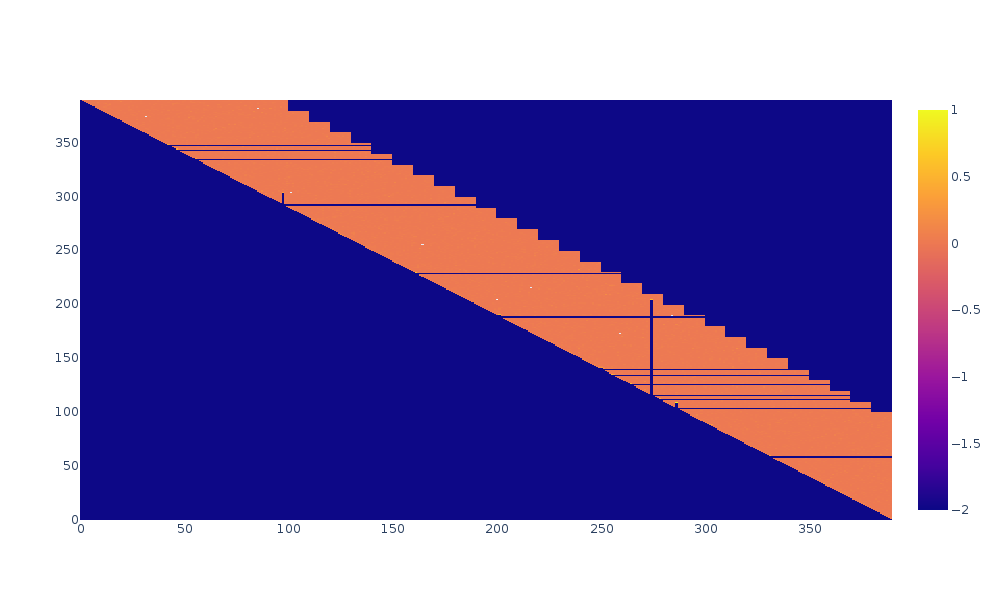

In [83]:
# Show R2 for all variants
fig = go.Figure(data=[go.Heatmap(z=r2[::-1])])
Image(fig.to_image('png', width=1000, height=600))

### Results (With Short-Circuit)

In [75]:
# Number of pairwise correlations computed
(r2 >= 0).sum()

23979

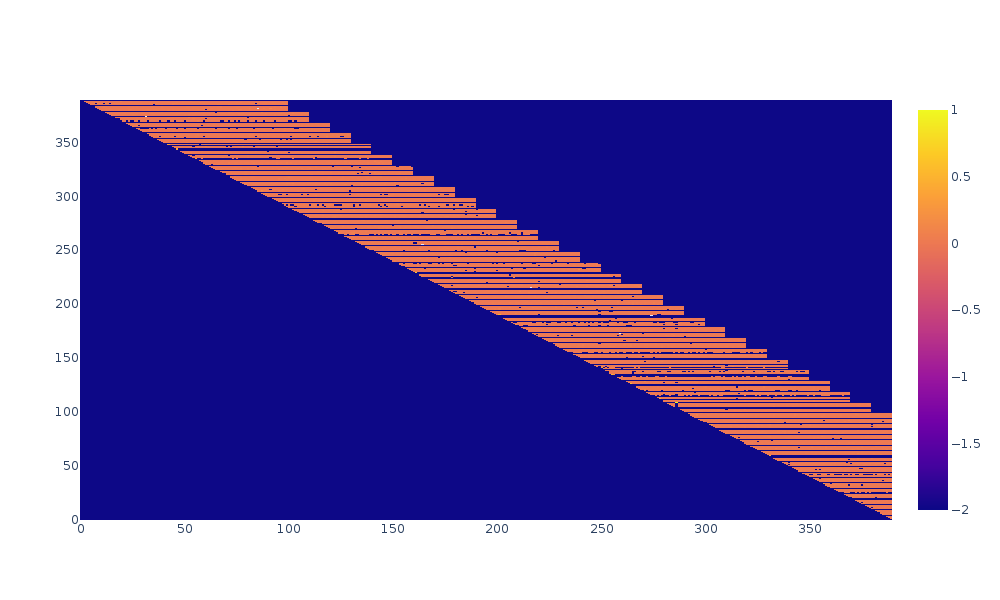

In [76]:
# Show R2 for all variants
fig = go.Figure(data=[go.Heatmap(z=r2[::-1])])
Image(fig.to_image('png', width=1000, height=600))